In [101]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [102]:
import numpy as np
import pandas as pd

In [103]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [104]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [105]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [106]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [107]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [108]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [109]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [110]:
first_row_measure = session.query(Measurement).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1186740f0>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [111]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x118674438>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [112]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [113]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [114]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [115]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [116]:
# Get date for the past one year



max_date_qry = session.query(func.max(Measurement.date))
for x in max_date_qry:
    max_date=x[0]
    print(max_date)

max_dt_v = datetime.strptime(max_date,'%Y-%m-%d')
print(max_dt_v)

one_year_b4 = max_dt_v - dt.timedelta(days=366)
print(one_year_b4)





2017-08-23
2017-08-23 00:00:00
2016-08-22 00:00:00


([], <a list of 0 Text xticklabel objects>)

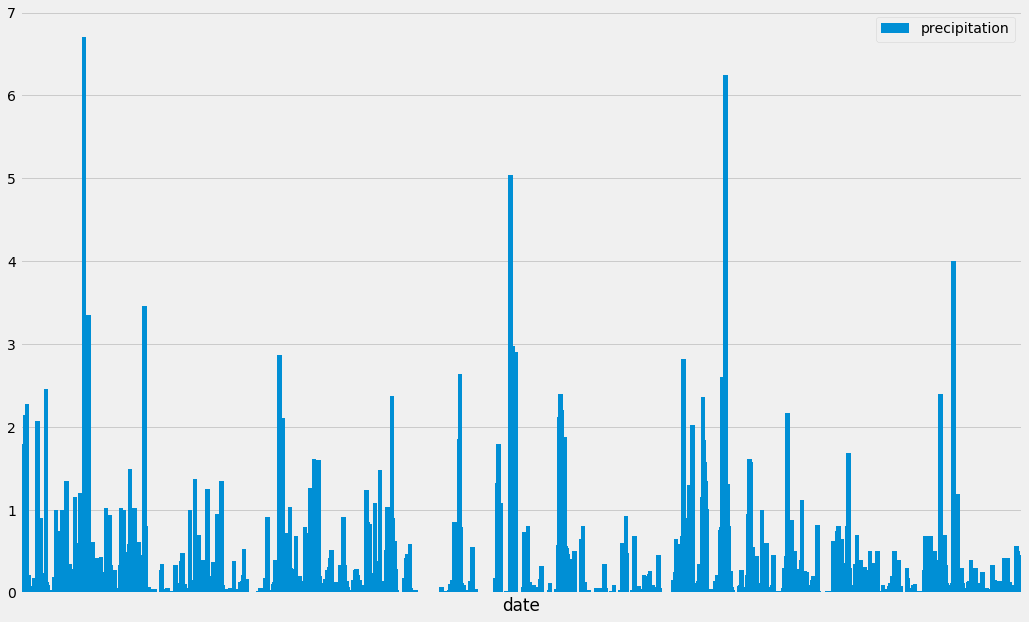

In [117]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = session.query(Measurement.date , Measurement.prcp ).\
            filter(Measurement.date >= one_year_b4).\
            order_by(Measurement.date).\
            all() 

# Save the query results as a Pandas DataFrame and set the index to the date column

data_df = pd.DataFrame(data, columns=['date', 'precipitation'])
data_df.set_index('date', inplace=True, )

# Sort the dataframe by date

data_df_sort = data_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
data_df_sort.plot(kind='bar', figsize=(16,10), width=10)

plt.xticks([])




In [118]:
# Use Pandas to calcualte the summary statistics for the precipitation data


data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [119]:
# Design a query to show how many stations are available in this dataset?

session.query(Station.station).group_by(Station.station).count()

9

In [120]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


session.query(Station.station, func.count(Measurement.station) ).\
group_by(Measurement.station).\
filter(Measurement.station == Station.station).\
order_by(desc(func.count(Measurement.station))).\
all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [121]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


session.query( func.min(Measurement.tobs), func.max(Measurement.tobs) , func.avg(Measurement.tobs) ).\
        filter(Measurement.station == 'USC00519281').\
        all()




[(54.0, 85.0, 71.66378066378067)]

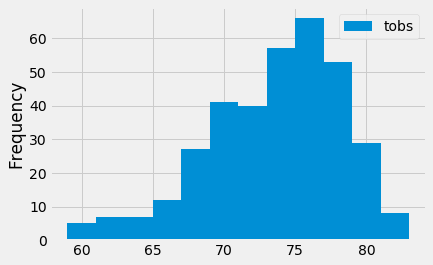

In [122]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


temp_data = session.query( Measurement.tobs ).\
                    filter(Measurement.date >= one_year_b4).\
                    filter(Measurement.station == 'USC00519281').\
                    all() 

temp_df = pd.DataFrame(temp_data)

temp_df.plot(kind='hist',bins=12)

In [123]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [130]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

one_year_b4_mth = one_year_b4 + dt.timedelta(days=10)
print(str(one_year_b4)+'****'+ str(one_year_b4_mth))

temp_range = calc_temps(one_year_b4, one_year_b4_mth)
print(temp_range)


2016-08-22 00:00:00****2016-09-01 00:00:00
[(71.0, 78.32307692307693, 84.0)]


78.32307692307693
13.0


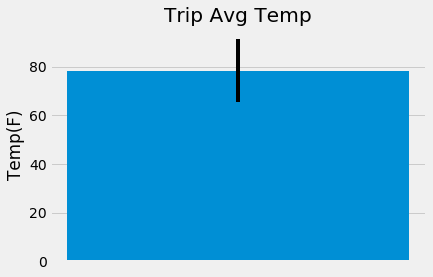

In [131]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = temp_range[0][1]
y_err = temp_range[0][2] - temp_range[0][0]
print(avg_temp)
print(y_err)

x_pos=1
plt.title('Trip Avg Temp')
plt.bar(x_pos,avg_temp, yerr=y_err)
plt.ylabel('Temp(F)')
plt.xticks([])
plt.show()

In [132]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_strt_prior_yr = one_year_b4 - dt.timedelta(days=366)

trip_end_prior_yr = one_year_b4_mth  - dt.timedelta(days=366)

print(trip_strt_prior_yr)
print(trip_end_prior_yr)

session.query( Measurement.station , Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp) ).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > trip_strt_prior_yr).\
                    filter(Measurement.date < trip_end_prior_yr).\
                    filter(Measurement.station == Station.station).\
                    order_by(desc(func.sum(Measurement.prcp))).\
                    all()


2015-08-22 00:00:00
2015-09-01 00:00:00


[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  10.780000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  9.359999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  6.64),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  4.83),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.68),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2.1),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.94),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 1.5)]

## Optional Challenge Assignment

In [128]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [183]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

print(trip_strt_prior_yr)
print(trip_end_prior_yr)

# Use the start and end date to create a range of dates

date_range = [trip_strt_prior_yr + dt.timedelta(days=x) for x in range(0, (trip_end_prior_yr-trip_strt_prior_yr).days)]

#print(date_range)

date_range_char=[]
for y in date_range:
    #date_range_char.append(y.strftime("%yyy-%m-%d"))
    date_range_char.append([y.strftime("%m-%d"),y.strftime("%Y-%m-%d")])
#print(date_range_char)


# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normal_list=[]
for z in date_range_char:
    #print(z[1])
    daily_normal_list.append([z[1],daily_normals(z[0])])
    
print(daily_normal_list)

new_list=[]
for x in daily_normal_list:
    new_list.append([x[0],x[1][0][0],x[1][0][1],x[1][0][2]])

print(new_list)

2015-08-22 00:00:00
2015-09-01 00:00:00
[['2015-08-22', [(69.0, 76.47169811320755, 84.0)]], ['2015-08-23', [(67.0, 76.6923076923077, 87.0)]], ['2015-08-24', [(70.0, 75.96153846153847, 84.0)]], ['2015-08-25', [(69.0, 76.96078431372548, 82.0)]], ['2015-08-26', [(71.0, 76.56862745098039, 84.0)]], ['2015-08-27', [(68.0, 76.28301886792453, 84.0)]], ['2015-08-28', [(67.0, 76.73469387755102, 86.0)]], ['2015-08-29', [(70.0, 76.23529411764706, 85.0)]], ['2015-08-30', [(68.0, 76.41666666666667, 84.0)]], ['2015-08-31', [(67.0, 76.84, 85.0)]]]
[['2015-08-22', 69.0, 76.47169811320755, 84.0], ['2015-08-23', 67.0, 76.6923076923077, 87.0], ['2015-08-24', 70.0, 75.96153846153847, 84.0], ['2015-08-25', 69.0, 76.96078431372548, 82.0], ['2015-08-26', 71.0, 76.56862745098039, 84.0], ['2015-08-27', 68.0, 76.28301886792453, 84.0], ['2015-08-28', 67.0, 76.73469387755102, 86.0], ['2015-08-29', 70.0, 76.23529411764706, 85.0], ['2015-08-30', 68.0, 76.41666666666667, 84.0], ['2015-08-31', 67.0, 76.84, 85.0]]


In [187]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df = pd.DataFrame(new_list,columns=('date','tmin','tavg','tmax'))
#new_df = df.set_index('date')
#new_df 


,tmin,tavg,tmax
date,,,
2015-08-22,69.0,76.471698,84.0
2015-08-23,67.0,76.692308,87.0
2015-08-24,70.0,75.961538,84.0
2015-08-25,69.0,76.960784,82.0
2015-08-26,71.0,76.568627,84.0
2015-08-27,68.0,76.283019,84.0
2015-08-28,67.0,76.734694,86.0
2015-08-29,70.0,76.235294,85.0
2015-08-30,68.0,76.416667,84.0


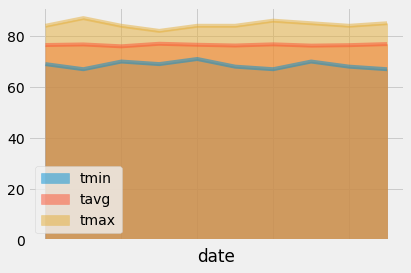

In [188]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(x='date', stacked=False)